In [1]:
import cvxpy as cp
import numpy as np

import torch
import torch.nn as nn
from model import TwolayerNet, MLP, AbstainNet
from torch.utils.data import DataLoader
from utils import load_data

import os
import time
from options import args_parser
from scipy.optimize import milp, Bounds
import matplotlib.pyplot as plt

from scipy.optimize import LinearConstraint

**load data**

In [2]:
class namespace:
    def __init__(self):
        self.batch_size=128
        self.device='cuda:1'
        self.epoch=30000
        self.hidden_dim=300
        self.input_dim=108
        self.load_from_disk=True
        self.lr=0.0005
        self.seed=1
        self.fairness_notion="DP"
        self.attribute="sex"
        self.type_of_abstain="prob"

args = namespace()

args.model_path = "../data/OptimalClassifier"
args.data_path = "../data/adult"

train_data, test_data = load_data(args)

**load functions**

In [3]:
def load_optimal(args):
    model = MLP(args)

    checkpoint = torch.load(os.path.join(args.model_path, "model_state.pth"), map_location="cpu")
    model.load_state_dict(checkpoint)

    model.to("cpu")
    model.eval()

    return model
def load_fair(args):
    model = AbstainNet(args)

    checkpoint = torch.load(os.path.join("../data/FairClassifier/DP_classifier"), map_location="cpu")
    model.load_state_dict(checkpoint)

    model.to("cpu")
    model.eval()

    return model

def load_abstain(args):
    model = AbstainNet(args)
    
    model_file = os.path.join("../data/AbstainClassifier", "abstain_classifier_" + \
                            args.type_of_abstain+"_" + \
                            args.fairness_notion + "_" + \
                            args.attribute + ".pth")
    
    checkpoint = torch.load(model_file, map_location="cpu")
    model.load_state_dict(checkpoint)
    
    model.to("cpu")
    model.eval()
    
    return model

def predict_abstain(model, data, pred_labels):
    X = data.X.numpy()
    X = np.column_stack((X, pred_labels))
    log_probs = model(torch.from_numpy(X).to(torch.float))
    return log_probs.detach().cpu().numpy().flatten()

def predict(model, data):
    log_probs = model(data.X)
    return ((log_probs[:, 1] >= 0.5) * 1).detach().cpu().numpy(), log_probs[:, 1].detach().cpu().numpy()

def formatted(numbers):
    return [f"{num*100:.2f}%" for num in numbers]

def plot_stats(
    y,
    pred_list,
    g1_indices, 
    g2_indices,
    legend = 0.3
):
    num_classifiers = len(pred_list)
    n = pred_list[0][0].shape[0]
    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    
    accu_list = []
    fair_list = []
    ar_list = []
    names = []
    for idx in range(len(pred_list)):
        pred_labels = pred_list[idx][0]
        name = pred_list[idx][-1]
        if len(pred_list[idx]) == 3:
            wn = pred_list[idx][1]
            total_error_sum = np.sum((pred_labels != y) * wn)
            g1_error_sum = np.sum(((pred_labels != y) * wn)[g1_indices])
            g2_error_sum = np.sum(((pred_labels != y) * wn)[g2_indices])
            total_error_rate = total_error_sum / np.sum(wn)
            g1_error_rate = g1_error_sum / np.sum(wn[g1_indices])
            g2_error_rate = g2_error_sum / np.sum(wn[g2_indices])
            
            total_fair = np.sum(pred_labels * wn) / n
            g1_fair = np.sum((pred_labels * wn)[g1_indices]) / g1_num
            g2_fair = np.sum((pred_labels * wn)[g2_indices]) / g2_num
            
            abstain_rate = [1 - np.sum(wn) / n,  
                            1 - np.sum(wn[g1_indices]) / g1_num, 
                            1 - np.sum(wn[g2_indices]) / g2_num]
            
            
        else:
            total_error = pred_labels != y
            g1_error = (pred_labels != y)[g1_indices]
            g2_error = (pred_labels != y)[g2_indices]

            g1_error_rate = np.sum(g1_error) / g1_num
            g2_error_rate = np.sum(g2_error) / g2_num
            total_error_rate = np.sum(total_error) / n

            total_fair = np.sum(pred_labels) / n
            g1_fair = np.sum(pred_labels[g1_indices]) / g1_num
            g2_fair = np.sum(pred_labels[g2_indices]) / g2_num
            
            abstain_rate = [0, 0, 0]
            
        accu_list.append([1 - total_error_rate, 1 - g1_error_rate, 1 - g2_error_rate])
        fair_list.append([total_fair, g1_fair, g2_fair])
        ar_list.append(abstain_rate)
        names.append(name)
        
    plt.rcParams.update({'font.size': 15})

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    #accuracy
    bar_width = 1 / (num_classifiers + 1)
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    start = x_pos - int(num_classifiers / 2) * bar_width
    
    for i in range(num_classifiers):
        ax[0,0].bar(start + i * bar_width, accu_list[i], width=bar_width, label=names[i])
        ax[0,0].set_ylim([0.4, 1])
        ax[0,0].set_ylabel("Accuracy")
        ax[0,0].set_title("Accuracy")
        ax[0,0].set_xticks(x_pos)
        ax[0,0].set_xticklabels(x_labels)
        ax[0,0].legend(loc="upper right", framealpha=legend)

    

    #fairness
    bar_width = 1 / (num_classifiers + 1)
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    start = x_pos - num_classifiers / 2 * bar_width
    for i in range(num_classifiers):
        ax[0,1].bar(start + i * bar_width, fair_list[i], width=bar_width, label=names[i])
        ax[0,1].set_ylabel('$P(\\hat{y} = 1 | G)$')
        ax[0,1].set_title("Demographic Parity")
        ax[0,1].set_xticks(x_pos)
        ax[0,1].set_xticklabels(x_labels)
        ax[0,1].legend(loc="upper right", framealpha=legend)

    #proportion
    ax[1,0].pie([g1_num, g2_num], labels=['G1', 'G2'], autopct='%1.1f%%', startangle=90)
    ax[1,0].set_title('Proportion')

    #abstain rate
    bar_width = 1 / (num_classifiers + 1)
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    start = x_pos - num_classifiers / 2 * bar_width
    for i in range(num_classifiers):
        if ar_list[i][0] != 0:
            ax[1,1].bar(start + i * bar_width, ar_list[i], width=bar_width, label=names[i])
    ax[1,1].set_ylabel('Abstain Rate')
    ax[1,1].set_title("Abstain Rate")
    ax[1,1].set_xticks(x_pos)
    ax[1,1].set_xticklabels(x_labels)
    ax[1,1].legend(loc="upper right", framealpha=legend)

    fig.savefig('figure_me.png', bbox_inches='tight')
#     fig.suptitle(args.attribute + " as Sensitive Attribute(G1=Male, G2=Female, "+ '$\delta=$' + str(delta) + ', $\epsilon=$' + str(epsilon) +")", fontsize=30)

    for i in range(num_classifiers):
        print("=="+names[i]+"==\n")
        print("Accuracy", " ".join(formatted(accu_list[i])))
        print("P(\hat{y} = 1 | G)", " ".join(formatted(fair_list[i])))

        print()


**load optimal classifier and get stats**

In [4]:
data = train_data

**IP ptimazation function**

In [13]:
def IP(delta, epsilon, eta, sigma, data, pred_labels):

    X = data[0].numpy()
    y = data[1].numpy().astype(int)

    n = X.shape[0]
    g2_indices = np.where(X[:, 64] == 1)[0]
    g1_indices = np.where(X[:, 65] == 1)[0]

    g1_v = (X[:, 65] == 1) * 1
    g2_v = (X[:, 64] == 1) * 1

    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    g1_error = (pred_labels != y)[g1_indices]
    g2_error = (pred_labels != y)[g2_indices]
    g1_error_rate = np.sum(g1_error) / g1_num
    g2_error_rate = np.sum(g2_error) / g2_num
    total_error_rate = np.sum(total_error) / n
    
    zero_vector = np.zeros_like(y)
    zero_matrix = np.zeros((n, n))
    
    a = np.hstack([1 - 2 * y, y, zero_vector])
#     print("a", a.shape)
    
    
    c1 = np.stack(
        [
            np.hstack([g1_v / g1_num - g2_v / g2_num, np.zeros(2*n)]), 
            np.hstack([g2_v / g2_num - g1_v / g1_num, np.zeros(2*n)]),
        ]
    )
#     print("c1", c1.shape)
    cons1 = epsilon * np.ones(2)

    c2 = np.stack(
        [
            np.hstack([zero_vector, g1_v, zero_vector]),
            np.hstack([zero_vector, g2_v, zero_vector]),
        ]
    )
#     print("c2", c2.shape)
    cons2 = np.array([(1 - delta) * g1_num, (1 - delta) * g2_num])

    
    g1_v - 2 * g1_v * y
    r1 = (g1_error_rate + eta - eta * g1_error_rate) * g1_v - g1_v * y
    r2 = (g2_error_rate + eta - eta * g2_error_rate) * g2_v - g2_v * y
    
    c3 = np.stack([
        np.hstack([g1_v - 2 * g1_v * y, -r1, zero_vector]),
        np.hstack([g2_v - 2 * g2_v * y, -r2, zero_vector]),
    ])
#     print("c3", c3.shape)
    cons3 = np.zeros(2)
    
    I = np.eye(n)
    c4 = np.concatenate([I, -I, zero_matrix], axis=1)
    cons4 = np.zeros(n)
#     print("c4", c4.shape)
    
    c5 = np.concatenate([I, zero_matrix, -I], axis=1)
    cons5 = cons4
    
    c6 = np.concatenate([-I, I, I], axis=1)
    cons6 = np.ones_like(y)
    if type(sigma) != list:
        c7 = np.stack(
            [
                np.hstack([np.zeros(n), g1_v / g1_num - g2_v / g2_num, np.zeros(n)]),
                np.hstack([np.zeros(n), g2_v / g2_num - g1_v / g1_num, np.zeros(n)])
            ]
        )
        cons7 = np.array([sigma, sigma])
    else:
        c7 = np.stack(
            [
                np.hstack([np.zeros(n), g1_v * y / np.sum(g1_v * y) - g2_v * y / np.sum(g2_v * y), np.zeros(n)]),
                np.hstack([np.zeros(n), g2_v * y / np.sum(g2_v * y) - g1_v * y / np.sum(g1_v * y), np.zeros(n)]),
                np.hstack([np.zeros(n), g1_v * (1 - y) / np.sum(g1_v * (1 - y)) - g2_v * (1 - y) / np.sum(g2_v * (1 - y)), np.zeros(n)]),
                np.hstack([np.zeros(n), g2_v * (1 - y) / np.sum(g2_v * (1 - y)) - g1_v * (1 - y) / np.sum(g1_v * (1 - y)), np.zeros(n)])
            ]
        )
        sigma0, sigma1 = sigma[0], sigma[1]
        cons7 = np.array([sigma1, sigma1, sigma0, sigma0])
        

    

    lower_bounds = np.zeros_like(a)
    upper_bounds = np.ones_like(a)

    constraints = [
        LinearConstraint(c1, ub=cons1),
        LinearConstraint(c2, lb=cons2),
        LinearConstraint(c3, ub=cons3),
        LinearConstraint(c4, ub=cons4),
        LinearConstraint(c5, ub=cons5),
        LinearConstraint(c6, ub=cons6),
        LinearConstraint(c7, ub=cons7),
    ]
    integrality = np.ones_like(a)
    res = milp(
        c=a, 
        constraints=constraints, 
        integrality=integrality, 
        bounds=Bounds(lower_bounds, upper_bounds)
    )
    kn = res.x
    
    num_kn = kn.shape[0]
    interval = int(num_kn / 3)
    wn = kn[interval:2*interval]
    hn = kn[2*interval:]
    return wn, hn

def process_wn(wn, pred_labels):
    if wn is None:
        print("Not feasible!")
        return None
    else:
        plt.plot(np.sort(wn))
        plt.title("$w_n$ for each data point")
        plt.xlabel("data points")
        plt.ylabel("value")
        
        return (wn * pred_labels)
    
def semi_fair(optimal_classifier, fair_classifier, data, p = 0.5):
    pred_optimal, _ = predict(optimal_classifier, data)
    pred_fair = (predict_abstain(fair_classifier, data, pred_labels) >= 0.5) * 1
    
    mask = (pred_optimal != pred_fair)
    c = np.copy(pred_optimal)
    c[mask] = np.where(np.random.random(mask.sum()) < p, pred_fair[mask], c[mask])
    return c

**Solve and plot, tune hyperparameter here**

In [14]:
optimal_classifier = load_optimal(args)
# fair_classifier = load_fair(args)
pred_labels, pred_probs = predict(optimal_classifier, train_data)

In [15]:
epsilon = 0.03
eta = 0

In [19]:
n = 30000
data = train_data[:n]
pred_labels = pred_labels[:n]

In [22]:
X = data[0].numpy()
y = data[1].numpy().astype(int)
g2_indices = np.where(X[:, 64] == 1)[0]
g1_indices = np.where(X[:, 65] == 1)[0]

# print("Use wn as abstain result\n")

#solve IP
pred_list = [[pred_labels, "Opt."],]
delta_list = [0.18, 0.2]
sigma_list = [0.01, 0.1, 1]
for delta in delta_list:
    for sigma in sigma_list:
        print(delta, sigma)
        wn, hn = IP(delta, epsilon, eta, sigma, data, pred_labels)
        pred_list.append([hn, wn, "IP, $\delta=" + str(delta) + ", " + "\sigma=" + str(sigma) +"$"])
    


==Opt.==

Accuracy 92.80% 91.62% 95.95%
P(\hat{y} = 1 | G) 48.80% 57.39% 25.77%

==IP, $\delta=0.18, \sigma=0.01$==

Accuracy 94.20% 93.53% 96.00%
P(\hat{y} = 1 | G) 34.07% 34.87% 31.90%

==IP, $\delta=0.18, \sigma=0.1$==

Accuracy 94.57% 93.97% 95.99%
P(\hat{y} = 1 | G) 34.43% 35.24% 32.27%

==IP, $\delta=0.18, \sigma=1$==

Accuracy 94.90% 94.42% 95.95%
P(\hat{y} = 1 | G) 34.80% 35.61% 32.64%

==IP, $\delta=0.2, \sigma=0.01$==

Accuracy 95.79% 95.71% 96.01%
P(\hat{y} = 1 | G) 33.93% 34.74% 31.78%

==IP, $\delta=0.2, \sigma=0.1$==

Accuracy 96.11% 96.17% 95.96%
P(\hat{y} = 1 | G) 34.30% 35.10% 32.15%

==IP, $\delta=0.2, \sigma=1$==

Accuracy 96.53% 96.80% 95.95%
P(\hat{y} = 1 | G) 34.80% 35.61% 32.64%



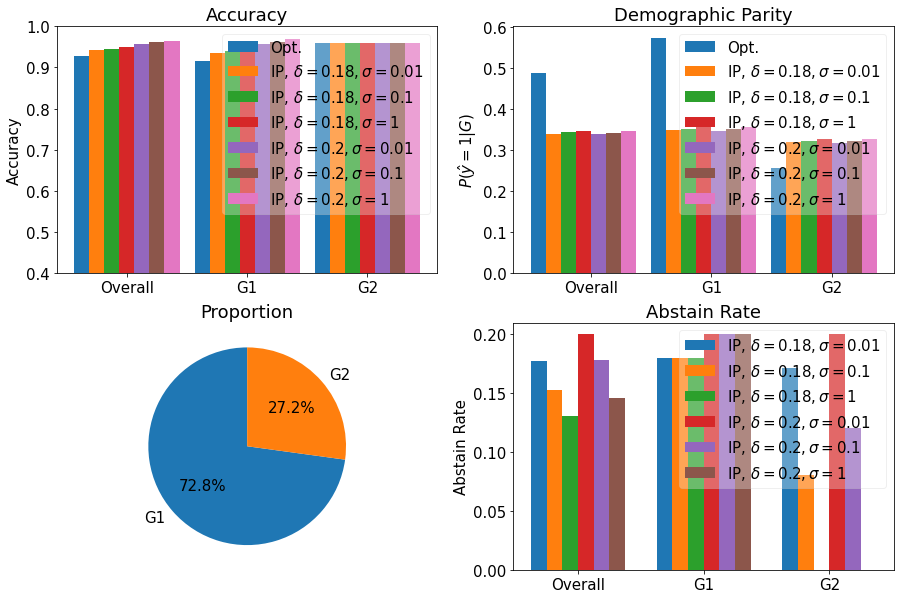

In [133]:
plot_stats(
    y,
    pred_list,
    g1_indices, 
    g2_indices)

In [146]:
# epsilon = 0.03
eta = 0.1

X = data[0].numpy()
y = data[1].numpy().astype(int)
g2_indices = np.where(X[:, 64] == 1)[0]
g1_indices = np.where(X[:, 65] == 1)[0]

# print("Use wn as abstain result\n")

#solve IP
pred_list = [[pred_labels, "Opt."],]
delta_list = [0.2]
sigma_list = [[0.05, 0.05], [1, 1]]
for delta in delta_list:
    for sigma in sigma_list:
        print(delta, sigma)
        wn, hn = IP(delta, epsilon, eta, sigma, data, pred_labels)
        pred_list.append([hn, wn, "IP, $\delta=" + str(delta) + ", " + "\sigma_{-}=" + str(sigma[0]) + ", " + "\sigma_{+}=" + str(sigma[1])+"$"])


0.2 [0.05, 0.05]
0.2 [1, 1]


==Opt.==

Accuracy 92.80% 91.62% 95.95%
P(\hat{y} = 1 | G) 48.80% 57.39% 25.77%

==IP, $\delta=0.2, \sigma_{-}=0.05, \sigma_{+}=0.05$==

Accuracy 93.62% 96.68% 86.46%
P(\hat{y} = 1 | G) 34.70% 35.51% 32.52%

==IP, $\delta=0.2, \sigma_{-}=1, \sigma_{+}=1$==

Accuracy 97.75% 100.00% 91.72%
P(\hat{y} = 1 | G) 37.37% 38.17% 35.21%



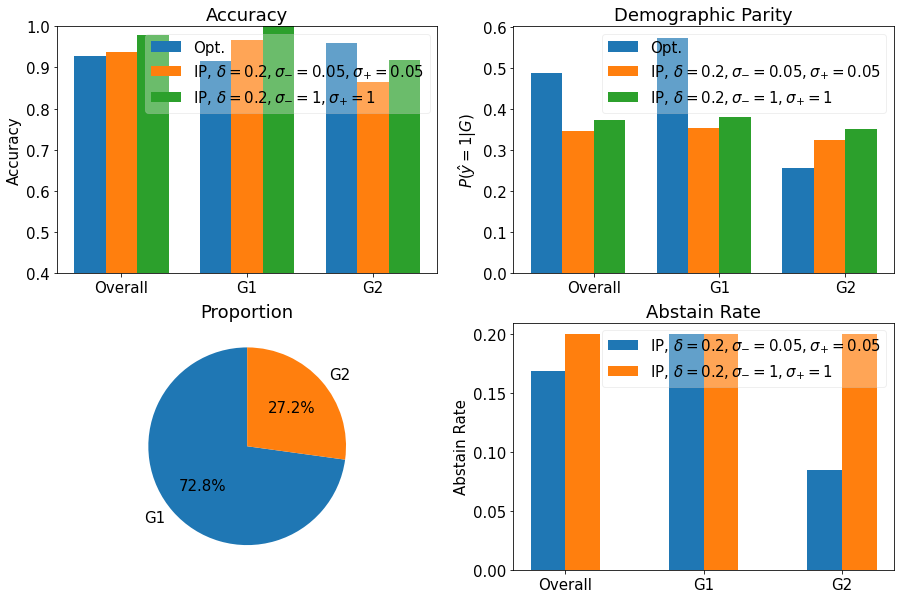

In [147]:
plot_stats(
    y,
    pred_list,
    g1_indices, 
    g2_indices)